# Simulating Network Deliberation 

In [57]:
# Configure plotting in Jupyter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (20, 20),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})
# Seed random number generator
import random
from numpy import random as nprand
from tqdm import tqdm

In [2]:
# Import NetworkX
import networkx as nx
import numpy as np

### Assign nodes to groups 

In [3]:
from learning import *
from learning.evaluate import *
from learning.noisy import *
from learning.plot import *
from learning.strategy import *

In [4]:
from topologies import *

## Generates topologies

In [5]:
def generate_long_path(N, M, stage):
    '''Generates a long path network
    #Parameters:
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a long path network
    '''

    groups = get_long_path_stage_groups(N, M, stage)
    G = nx.Graph()
    for group in groups:
        g = nx.complete_graph(group) #clique network
        G = nx.union(G,g)
    return G

In [6]:
def generate_random_path(N, M, stage):
    """ Generates a radom network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a long path network
    
    """
    groups = get_random_stage_groups(N, M, stage)
    #print("all the groups", groups)
    G = nx.Graph()
    for group in groups:
        g = nx.complete_graph(group) #clique network
        G = nx.union(G,g)
    return G

In [7]:
def generate_sw(N, M, stage):
    '''Generates a small world network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a SW network
    '''
    return nx.watts_strogatz_graph(N, 4, 0.1)

In [8]:
def generate_preferential(N, M, stage):
    '''Generates a small world network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a preferential attachment network
    '''
    return nx.barabasi_albert_graph(N, 2)


In [9]:
def generate_complete(N, M, stage):
    '''Generates a complete network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a complete network
    '''
    return nx.complete_graph(N)

In [10]:
def generate_random(N, M, stage):
    ##NOTE the probability is too low. 

    '''Generates a karate club network
    #Parameters
    N: number of participants 
    M: number of participants per group
    stage: stage in the ;earning process
    
    #Returns 
    a random network
    '''
    return nx.erdos_renyi_graph(N, 0.04)

## run_trial

In [22]:
def run_trial(
    Graph,
    p_error,
    learning_strategy,
    true_value,
    runs,
    N,
    M,
    stages,
    steps,
    stage_graphs=False
):
    """
    Plots the fraction of correct nodes in all stages of a simulation
    
    #Parameters:
    Graph: topology
    learning strategy: learning strategy to simulate in topology
    intial beliefs are generated inside the topology: prarms (G, true_value, p_error)
    true_value: the ground truth 
    runs: the number of runs 
    stage_graphs: checks if the graph needs to be change in subsequent stages
    stages: for now is fixed, eventually will change. (fixed for now) 
    
    return
    a dictrionary of lists. the keys are the number of the run, and the val is the fract of nodes with correct beliefs
    """

    #keep values of each run: key: # run val: plot_belief_bits_correct
    runs_list_fract_corrrect = dict(
        (run, list())
        for run in range(runs)) #for each bit creates an empty list. 
    
    for run in range(runs):
        beliefs_stages = []
    
        for stage in range(stages):

            if stage == 0: 
                G = Graph(N, M, stage)
                ini_beliefs = initial_beliefs_noisy(G, true_value, p_error=p_error)
                beliefs_stages = [ini_beliefs]
            else:
                if stage_graphs:
                    G = Graph(N, M, stage)
                ini_beliefs = beliefs_stages[-1]
                
            beliefs_list = learn(G, ini_beliefs, learning_strategy, true_value, steps)
            beliefs_stages += beliefs_list[1:]
            
        runs_list_fract_corrrect[run] += beliefs_correct(beliefs_stages, true_value)
    return runs_list_fract_corrrect

In [23]:
def sta_des_all_runs(Graph, p_error, learning_strategy, true_value, runs, N, M, stages, steps, stage_graphs=True):
    '''Takes the values of all runs and finds the mean and std dev
    #Parameters 
    Graph: given topology/network 
    learning_strategy: learning strategy to simulate in topology
    true_value: the ground truth 
    runs: the number of runs 
    stage_graphs: checks if the graph needs to be change in subsequent stages
    
    #Returns a plot of mean value of all the runs with a bar error
    '''
    runs_list_fract_corrrect = run_trial(
        Graph,
        p_error,
        learning_strategy, 
        true_value,
        runs,
        N, M, stages, steps,
        stage_graphs)

    #runs && num_stpes are use to iterate through each step 
    runs = list(runs_list_fract_corrrect.keys())
    #total num of steps each run
    num_steps = len(runs_list_fract_corrrect[runs[0]])

    #keep values of all the values in each index: key: index; val: fraction of nodes
    fract_corrrect_step = dict(
        (step, list())
        for step in range(num_steps)) #for each bit creates an empty list. 

    for run in runs_list_fract_corrrect:
        for step in range(num_steps):
            #gets the fraction of nodes at step [step]
            #appends the raction of nodes at step [step] to fract_corrrect_step[step] dictrionary
            fract_corrrect_step[step].append(runs_list_fract_corrrect[run][step])

    y = []
    y_error = []
    for step in fract_corrrect_step:
        mean_each_step = np.mean(fract_corrrect_step[step])
        sd_each_step = np.std(fract_corrrect_step[step])
        
        y.append(mean_each_step)
        y_error.append((1.96*sd_each_step/len(fract_corrrect_step[step])**.5))
    
    x = range(len(y))
    plt.errorbar(x, y, yerr = y_error, fmt='-o', ecolor='g', capthick=2)

    #add spines to plot
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
    plt.xlim([0, len(x)])
    plt.ylim([0, 1.1])

In [24]:
networks = {
            'Long Path': (generate_long_path, True),
            'Random Path': (generate_random_path, True),
            'Preferential Attachment': (generate_preferential, False),
            'Small World': (generate_sw, False),
            'Complete Network': (generate_complete, False)
            }

In [25]:
learning_strategies = {
            'Local Majority': local_majority,
            'Random bit': random_neighbor_bit,
            'Random list': random_neighbor_list,
            'Conform': conform,
            'Best neighbor': best_neighbor
            }

# Simulations 

In [58]:
def run(bit_count, p_error, runs, N, M, stages, steps):
    for j, (title, (Graph, sg)) in tqdm(enumerate(networks.items())):
        for i, (title2, learning_strategy) in enumerate(learning_strategies.items()):
                plt.subplot(
                    len(networks),
                    len(learning_strategies),
                    1 + j * len(learning_strategies) + i)
                plt.title(f'{title} x {title2}')
                plt.grid(True)
                sta_des_all_runs(
                    Graph,
                    p_error,
                    learning_strategy,
                    tuple([1 for x in range(bit_count)]),
                    runs,
                    N, M, stages, steps,
                    stage_graphs=sg)
    plt.tight_layout()

5it [04:15, 59.04s/it]


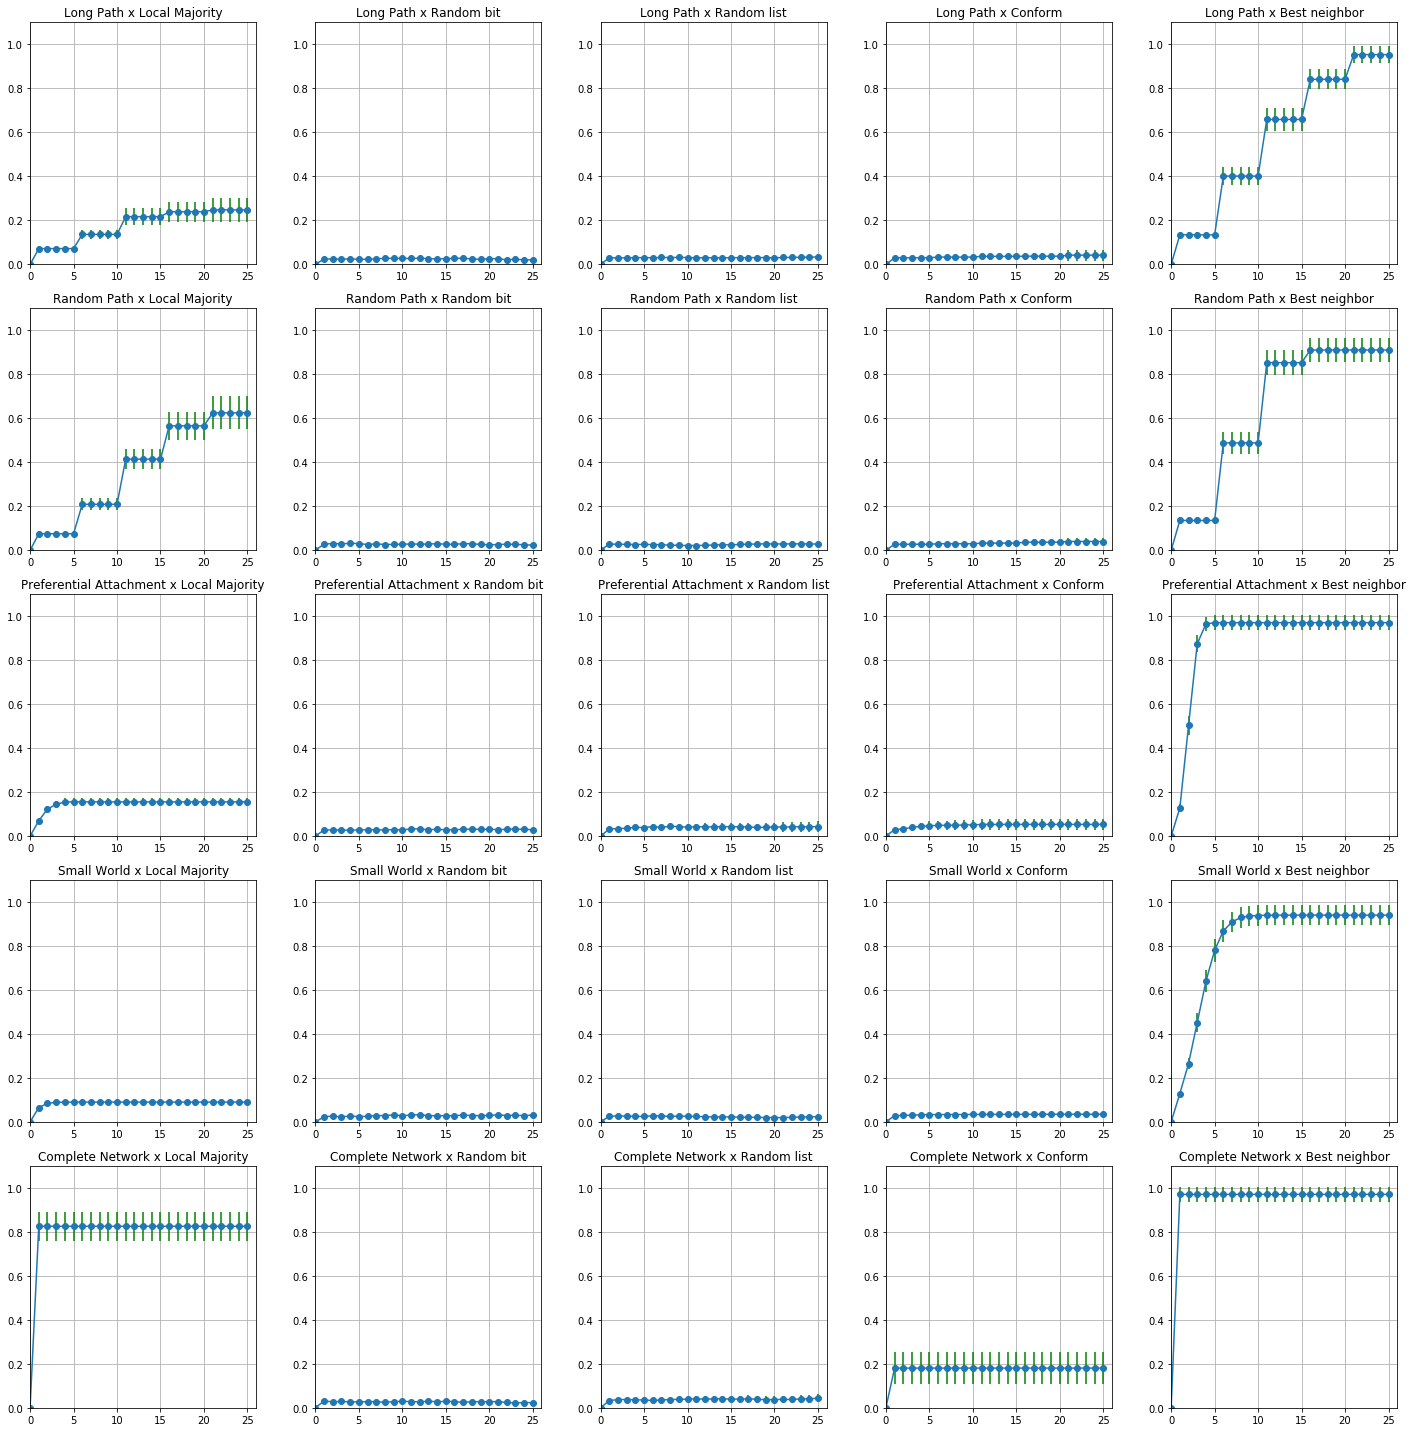

In [60]:
bit_count = 7
p_error = 0.4
runs = 100
N = 100
M = 5
stages = 5
steps = 5
run(bit_count, p_error, runs, N, M, stages, steps)